# Forecasting Daily Cargo Revenue 

## 1. Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Set plot style
plt.style.use('ggplot')

# Load the dataset
df = pd.read_csv(r"C:\Users\superadmin\Documents\Tech Projects\Qatar Airways - Cargo Data Analyst\data\raw\daily_operations.csv")

# Display basic info
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (397, 9)


,date,total_shipments,total_revenue_usd,total_weight_kg,operational_issues,staff_count,equipment_utilization_rate,weather_condition,temperature_celsius
0,2024-01-01,241,752546.89,115187.38,NaN,60,0.190223,Fog,30.546345
1,2024-01-02,249,940915.27,129665.42,NaN,44,0.227114,Storm,22.276070
2,2024-01-03,288,1010384.40,141480.55,NaN,50,0.558040,Clear,30.636687
3,2024-01-04,249,860764.47,131209.77,NaN,51,0.440878,Storm,24.238909
4,2024-01-05,237,738407.89,114034.51,NaN,47,0.598330,Fog,20.902952


## 2. Feature Engineering & Preprocessing

In [3]:
# 1. Convert date to datetime object
df['date'] = pd.to_datetime(df['date'])

# 2. Extract time-based features
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Handle categorical 'weather_condition' using One-Hot Encoding
df = pd.get_dummies(df, columns=['weather_condition'], prefix='weather')

# 4. Drop columns that won't be used for prediction
# 'operational_issues' has too many missing values, and 'date' is now represented by features.
cols_to_drop = ['date', 'operational_issues']
data_prepared = df.drop(columns=cols_to_drop)

# Remove rows with 0 revenue (outliers/missing days if any)
data_prepared = data_prepared[data_prepared['total_revenue_usd'] > 0]

print("Features selected for training:")
print(data_prepared.columns.tolist())

Features selected for training:
['total_shipments', 'total_revenue_usd', 'total_weight_kg', 'staff_count', 'equipment_utilization_rate', 'temperature_celsius', 'month', 'day_of_week', 'is_weekend', 'weather_Clear', 'weather_Fog', 'weather_Rain', 'weather_Storm']


## 3. Exploratory Data Analysis (EDA)

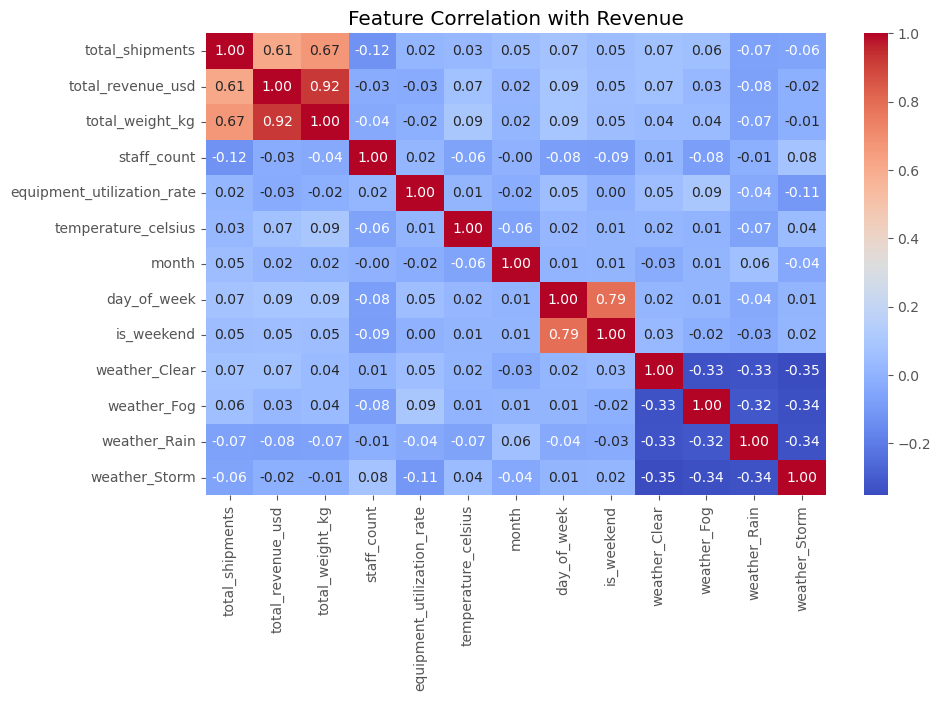

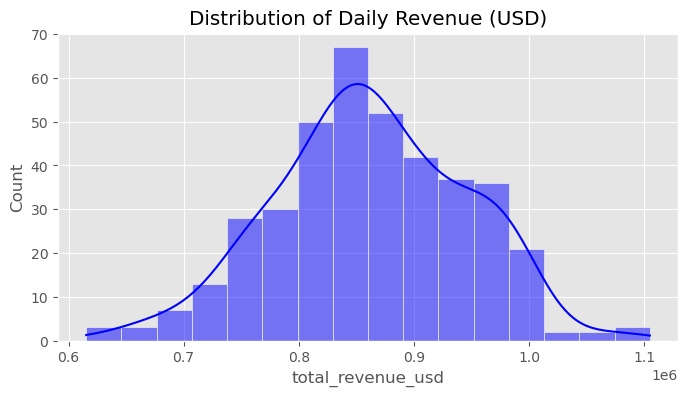

In [4]:
# Correlation heatmap to see which features impact revenue most
plt.figure(figsize=(10, 6))
sns.heatmap(data_prepared.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Revenue")
plt.show()

# Distribution of Revenue
plt.figure(figsize=(8, 4))
sns.histplot(data_prepared['total_revenue_usd'], kde=True, color='blue')
plt.title("Distribution of Daily Revenue (USD)")
plt.show()

## 4. Model Training

In [5]:
# Define Features (X) and Target (y)
X = data_prepared.drop('total_revenue_usd', axis=1)
y = data_prepared['total_revenue_usd']

# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


## 5. Evaluation and Visulization

Mean Absolute Error: $26,849.89
R-squared Score: 0.8238
Root Mean Squared Error: $33,512.41


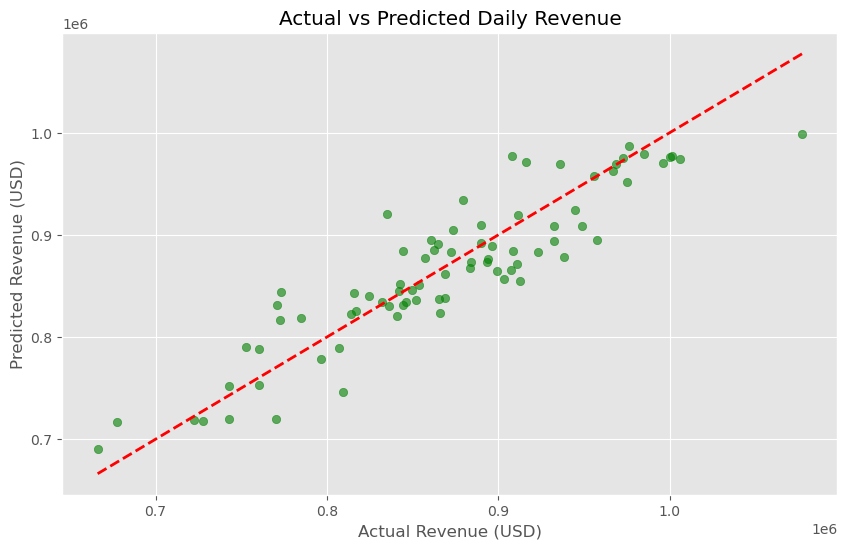

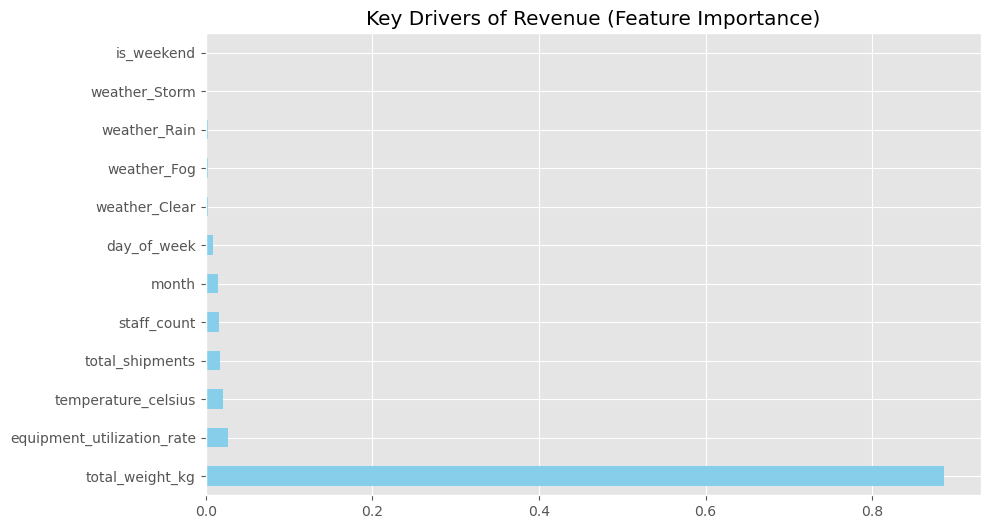

In [6]:
# Make Predictions
y_pred = model.predict(X_test)

# Calculate Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Root Mean Squared Error: ${rmse:,.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue (USD)')
plt.ylabel('Predicted Revenue (USD)')
plt.title('Actual vs Predicted Daily Revenue')
plt.show()

# Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='skyblue')
plt.title('Key Drivers of Revenue (Feature Importance)')
plt.show()